# Extended Trapping SINDy - Sparse testing
In "Local stability guarantees for data-driven quadratically nonlinear systems", we did not actually try to produce sparse solution for coefficients of the identified system, $\Xi$. The reason is that in fact we do not know if the system is truly sparse or how sparse it is even if it is truly sparse. We need a theorem or a benchmark to evaluate to what extent we can trust the sparse model discovered by the algorithm.

But before the evaluation, let us find out if the sparse regularizer will destroy our stability guarantees or the stability itself. We should remember that the conservative stability estimates given by the theorem do not reveal the exact long-term stability domain.

We will try to explore this by a few examples.

In [ ]:
import warnings

import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

import pysindy as ps
from pysindy.utils import *

# ignore warnings
warnings.filterwarnings("ignore")

# Import useful functions
from trapping_utils import (
    integrator_keywords,
    sindy_library,
    make_fits,
    obj_function,
    check_local_stability,
    make_trap_progress_plots,
)

: 

In [ ]:
# Atmospheric oscillator from Tuwankotta et al and Trapping SINDy paper
def oscillator(t, x, mu1=0.05, mu2=-0.01, omega=3.0, alpha=-2.0, beta=-5.0, sigma=1.1):
    return [
        mu1 * x[0] + sigma * x[0] * x[1] + 1e-3 * x[1] * x[2],
        mu2 * x[1] + (omega + alpha * x[1] + beta * x[2]) * x[2] - sigma * x[0] ** 2,
        mu2 * x[2] - (omega + alpha * x[1] + beta * x[2]) * x[1],
    ]

# Mean field model
python tuple size
    = \begin{bmatrix} \mu & -1 & 0 \\1 & \mu & 0 \\ 0 & 0 & -1 \\ \end{bmatrix}
    \begin{bmatrix} x \\ y \\z \end{bmatrix}
    + \begin{bmatrix}- xz \\ - yz \\ x^2 + y^2\end{bmatrix} = \mathbf{L}\mathbf{x} + \mathbf{Q}\mathbf{xx},
$$
where $\mathbf{L}$ and $\mathbf{Q}$ denote the linear and quadratic parts of the model, respectively.

In [ ]:
# define parameters
r = 3
mu = 1e-2
dt = 0.01
T = 500
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = np.random.rand(3) - 0.5
x_train = solve_ivp(meanfield, t_span, x0, t_eval=t, 
                    args=(mu,), **integrator_keywords).y.T
x0 = (mu, mu, 0)
x_test = solve_ivp(meanfield, t_span, x0, t_eval=t, 
                   args=(mu,), **integrator_keywords).y.T


Start training now without sparse regularization!

In [ ]:

# define hyperparameters
max_iter = 5000
eta = 1.0e5
alpha = 1e20
beta = 1e-8
threshold = 0.0
alpha_m = 1e-1 * eta


# run trapping SINDy algorithm
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    gamma=-1,
    alpha_m=alpha_m,
    alpha=alpha,
    beta=beta,
    max_iter=max_iter,
    verbose=True,
    )

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'meanfield')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'meanfield')
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print('Frobenius Error = ', E_pred)
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_local_stability(r, Xi, sindy_opt, mean_val)

# compute relative Frobenius error in the model coefficients
Xi_meanfield = np.zeros(Xi.shape)
Xi_meanfield[:r, :r] = np.asarray([[0.01, -1, 0], [1, 0.01, 0], [0, 0, -1]]).T
Xi_meanfield[r + 1, 0] = -1
Xi_meanfield[r + 2, 1] = -1
Xi_meanfield[r + 3, 2] = 1
Xi_meanfield[r + 4, 2] = 1
coef_pred = np.linalg.norm(Xi_meanfield - Xi) / np.linalg.norm(Xi_meanfield)
print('Frobenius coefficient error = ', coef_pred)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :], 
                            xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                            xdot_test[i, :], xdot_test[i, :])
print('Time-averaged derivative error = ', np.nanmean(deriv_error))

This shows that local stability works pretty well on both modeling and sparse identification for systems with strict EPNs. Now let us examine this on a little more complex system with a deviation from $\bm Q$ having zero totally symmetric part.

# Atmospheric oscillator model
$$
\begin{align}

    \frac{d}{dt}\begin{bmatrix}
    x \\ 
    y \\
    z \\
    \end{bmatrix} = \begin{bmatrix}
    \mu_1 & 0 & 0 \\
    0 & \mu_2 & \omega \\
    0 & -\omega & \mu_2 
    \end{bmatrix}\begin{bmatrix} 
    x \\ 
    y \\
    z 
    \end{bmatrix}
    +
    \begin{bmatrix}
    \sigma xy \\
    \kappa yz + \beta z^2 - (\sigma + \epsilon) x^2 \\
    - \kappa y^2 - \beta yz
    \end{bmatrix}.
\end{align}
$$

In [ ]:
# define parameters
r = 3
sigma = 1.1
beta = -5.0
eps = 0.01
k1 = 5
k2 = 1
mu1 = eps * k1
mu2 = -eps * k2
alpha = -2.0
omega = 3.0

# Make training and testing data
dt = 0.01
T = 40
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = np.random.rand(3) - 0.5
x_train = solve_ivp(oscillator, t_span, x0, t_eval=t, 
                    args=(mu1, mu2, omega, alpha, beta, sigma), 
                    **integrator_keywords).y.T
x0 = np.random.rand(3) - 0.5
x_test = solve_ivp(oscillator, t_span, x0, t_eval=t,
                   args=(mu1, mu2, omega, alpha, beta, sigma), 
                   **integrator_keywords).y.T

# define hyperparameters
max_iter = 5000
eta = 1.0e8
alpha = 1e20
beta = 1e-4
threshold = 0.0
alpha_m = 1e-1 * eta

# run trapping SINDy, reusing previous threshold, max_iter and constraints
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    gamma=-1,
    # alpha_m=alpha_m,
    alpha=alpha,
    beta=beta,
    max_iter=max_iter,
    verbose=True,
    )
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
L = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
print('Max deviation from the constraints = ', Q_sum)

# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'oscillator')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'oscillator')
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print('Frobenius error = ', E_pred)
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_local_stability(r, Xi, sindy_opt, mean_val)

# compute relative Frobenius error in the model coefficients
Xi_oscillator = np.zeros(Xi.shape)
Xi_oscillator[:r, :r] = np.asarray([[0.05, 0, 0], 
                                    [0, -0.01, 3.0], 
                                    [0, -3.0, -0.01]]).T
Xi_oscillator[r, 0] = 1.1
Xi_oscillator[r + 2, 1] = -2
Xi_oscillator[r + 3, 1] = -1.1 - 1e-3
Xi_oscillator[r + 5, 1] = -5
Xi_oscillator[r + 2, 2] = 5
Xi_oscillator[r + 4, 2] = 2
coef_pred = np.linalg.norm(Xi_oscillator - Xi) / np.linalg.norm(Xi_oscillator)
print('Frobenius coefficient error = ', coef_pred)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :], 
                            xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                            xdot_test[i, :], xdot_test[i, :])
print('Time-averaged derivative error = ', np.nanmean(deriv_error))

# Lorenz

The algorithm works pretty well on nonchaotic systems in general, but what about chaotic systems?

$$
\begin{align}
    \frac{d}{dt}\begin{bmatrix}
    x \\ 
    y \\
    z \\
    \end{bmatrix} &= \begin{bmatrix}
    -\sigma & \sigma & 0 \\
    \rho & -1 & 0 \\
    0 & 0 & -\beta
    \end{bmatrix}
    \begin{bmatrix}
    x \\
    y \\
    z
    \end{bmatrix}
    +
    \begin{bmatrix}
    0 \\
    -xz \\
    xy
    \end{bmatrix}, \qquad
    \mathbf{A}^S = \begin{bmatrix}
    -\sigma & \frac{1}{2}(\rho+\sigma - m_3) & \frac{1}{2}m_2 \\
    \frac{1}{2}(\rho+\sigma - m_3) & -1 & 0 \\
    \frac{1}{2}m_2 & 0 & -\beta 
    \end{bmatrix}.
\end{align}
$$

For Lorenz's choice of parameters, $\sigma = 10$, $\rho = 28$, $\beta  = 8/3$, this system is known to exhibit a stable attractor. For $\mathbf{m} = [0,m_2,\rho+\sigma]$ ($m_1$ does not contribute to $\mathbf{A}^S$ so we set it to zero),

$$
\begin{align}
    \mathbf{A}^S &= \begin{bmatrix}
    -\sigma & 0 & \frac{1}{2}m_2 \\
    0 & -1 & 0 \\
    \frac{1}{2}m_2 & 0 & -\beta 
    \end{bmatrix}, \qquad
    \lambda_1 = -1, \qquad \lambda_{\pm} = -\frac{1}{2}\left[\beta+\sigma \mp \sqrt{m_2^2 + (\beta-\sigma)^2}\right],
\end{align}
$$

so that if $\lambda_{\pm} < 0$, then $-2\sqrt{\sigma\beta} < m_2 < 2\sqrt{\sigma\beta}$. 
Our algorithm can successfully identify the optimal $\mathbf{m}$, and can be used to identify the inequality bounds on $m_2$ for stability.

In [ ]:
# define parameters
r = 3
N = int((r ** 2 + 3 * r) / 2.0) + 1

# make training and testing data
dt = 0.01
T = 40
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = [1, -1, 20]
x_train = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T
x0 = (np.random.rand(3) - 0.5) * 30
x_test = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T

max_iter = 20000
eta = 1.0e5
alpha = 1e20
beta = 1e-8
threshold = 0.0
alpha_m = 2e-1 * eta

# run trapping SINDy... no more constraints!
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    gamma=-1,
    # alpha_m=alpha_m,
    alpha=alpha,
    beta=beta,
    max_iter=max_iter,
    verbose=True,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_local_stability(r, Xi, sindy_opt, mean_val)
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))

In [ ]:
# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'lorenz')

Let us train again with $\ell_1$ regularizer.

In [ ]:
max_iter = 2000
eta = 1.0e3
alpha = 1e20
beta = 1e-8
threshold = 1e4
alpha_m = 2e-1 * eta

# run trapping SINDy... no more constraints!
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    gamma=-1,
    alpha_m=alpha_m,
    alpha=alpha,
    beta=beta,
    max_iter=max_iter,
    verbose=True,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
Lenergy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenergy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_local_stability(r, Xi, sindy_opt, mean_val)
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))

In [ ]:
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], 'r-')
ax1.plot(x_train_pred[:, 0], x_train_pred[:, 1], x_train_pred[:, 2], 'k-')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'b')
ax2.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, 2], 'k--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation + prediction')
fig.show()

Now let's do a sweep.

In [ ]:
thresholds = np.array([0, 10, 100, 1e3, 1e4, 1e5])
deviation = np.zeros(np.size(thresholds))
pred_loss = np.zeros(np.size(thresholds))
coef_error = np.zeros(np.size(thresholds))
r_ls = np.zeros(np.size(thresholds))
l0 = np.zeros(np.size(thresholds))

sigma = 10
rho = 28
beta = 8.0 / 3.0
Xi_lorenz = np.zeros(Xi.shape)
Xi_lorenz[:r, :r] = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]]).T
Xi_lorenz[r + 1, 1] = -1
Xi_lorenz[r, 2] = 1

for i in range(len(thresholds)):

    max_iter = 2000
    eta = 1.0e5
    alpha = 1e20
    beta = 1e-8
    threshold = 0.1
    alpha_m = 2e-1 * eta

    if thresholds[i] == 0:
        max_iter = 20000

    # run trapping SINDy... no more constraints!
    sindy_opt = ps.TrappingSR3(
        threshold=thresholds[i], eta=eta,
        gamma=-1,
        alpha_m=alpha_m,
        alpha=alpha,
        beta=beta,
        max_iter=max_iter,
        verbose=False,
    )
    model = ps.SINDy(
        optimizer=sindy_opt,
        feature_library=sindy_library,
    )
    model.fit(x_train, t=t)
    model.print()
    Xi = model.coefficients().T
    x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

    PL_tensor = sindy_opt.PL_
    PQ_tensor = sindy_opt.PQ_
    mean_val = np.mean(x_test_pred, axis=0)
    mean_val = np.sqrt(np.sum(mean_val ** 2))
    rm, r_ls[i] = check_local_stability(r, Xi, sindy_opt, mean_val)
    Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
    Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
    deviation[i] = np.max(np.abs(Q_sum))
    coef_error[i] = np.linalg.norm(Xi_lorenz - Xi) / np.linalg.norm(Xi_lorenz)
    pred_loss[i] = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
    nonzero_ind = np.abs(Xi) >= 1e-3
    nonzeros = np.zeros(np.shape(Xi))
    nonzeros[nonzero_ind] = 1
    l0[i] = np.count_nonzero(nonzeros)

Now draw these results!

In [ ]:
nonzero_ind = np.abs(Xi) >= 1e-3
nonzeros = np.zeros(np.shape(Xi))
nonzeros[nonzero_ind] = 1
l0[5] = np.count_nonzero(nonzeros)

fig1 = plt.figure(figsize=(8,4))
plt.plot(thresholds, deviation, label=r"$\epsilon_Q$", linewidth=3)
plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

fig2 = plt.figure(figsize=(8,4))
plt.plot(thresholds, pred_loss, label=r"prediction loss", linewidth=3)
plt.plot(thresholds, coef_error, label=r"coefficients error", linewidth=3)
plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

fig3 = plt.figure(figsize=(8,4))
plt.plot(thresholds, r_ls, label=r"local stability radius", linewidth=3)
plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

fig4 = plt.figure(figsize=(8,4))
plt.plot(thresholds, l0, label=r"$\ell_0$ norm of coefficients", linewidth=3)

plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

In [ ]:
thresholds = np.arange(10, 460, 50)
deviation = np.zeros(np.size(thresholds))
pred_loss = np.zeros(np.size(thresholds))
coef_error = np.zeros(np.size(thresholds))
r_ls = np.zeros(np.size(thresholds))
l0 = np.zeros(np.size(thresholds))

sigma = 10
rho = 28
beta = 8.0 / 3.0
Xi_lorenz = np.zeros(Xi.shape)
Xi_lorenz[:r, :r] = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]]).T
Xi_lorenz[r + 1, 1] = -1
Xi_lorenz[r, 2] = 1

for i in range(len(thresholds)):

    max_iter = 2000
    eta = 1.0e5
    alpha = 1e20
    beta = 1e-8
    threshold = 0.1
    alpha_m = 2e-1 * eta

    if thresholds[i] == 0:
        max_iter = 20000

    # run trapping SINDy... no more constraints!
    sindy_opt = ps.TrappingSR3(
        threshold=thresholds[i], eta=eta,
        gamma=-1,
        alpha_m=alpha_m,
        alpha=alpha,
        beta=beta,
        max_iter=max_iter,
        verbose=False,
    )
    model = ps.SINDy(
        optimizer=sindy_opt,
        feature_library=sindy_library,
    )
    model.fit(x_train, t=t)
    model.print()
    Xi = model.coefficients().T
    x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

    PL_tensor = sindy_opt.PL_
    PQ_tensor = sindy_opt.PQ_
    mean_val = np.mean(x_test_pred, axis=0)
    mean_val = np.sqrt(np.sum(mean_val ** 2))
    rm, r_ls[i] = check_local_stability(r, Xi, sindy_opt, mean_val)
    Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
    Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
    deviation[i] = np.max(np.abs(Q_sum))
    coef_error[i] = np.linalg.norm(Xi_lorenz - Xi) / np.linalg.norm(Xi_lorenz)
    pred_loss[i] = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
    nonzero_ind = np.abs(Xi) >= 1e-3
    nonzeros = np.zeros(np.shape(Xi))
    nonzeros[nonzero_ind] = 1
    l0[i] = np.count_nonzero(nonzeros)

In [ ]:
nonzero_ind = np.abs(Xi) >= 1e-3
nonzeros = np.zeros(np.shape(Xi))
nonzeros[nonzero_ind] = 1
l0[5] = np.count_nonzero(nonzeros)

fig1 = plt.figure(figsize=(8,4))
plt.plot(thresholds, deviation, label=r"$\epsilon_Q$", linewidth=3)
plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

fig2 = plt.figure(figsize=(8,4))
plt.plot(thresholds, pred_loss, label=r"prediction loss", linewidth=3)
plt.plot(thresholds, coef_error, label=r"coefficients error", linewidth=3)
plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

fig3 = plt.figure(figsize=(8,4))
plt.plot(thresholds, r_ls, label=r"local stability radius", linewidth=3)
plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

fig4 = plt.figure(figsize=(8,4))
plt.plot(thresholds, l0, label=r"$\ell_0$ norm of coefficients", linewidth=3)

plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

## We also want to introduce the ZSINDy method to build in sparsity to the trapping models.

ZSindy is a recent strategy to directly construct sparse dynamical models without applying the traditional sparse regularization. Based on Bayesian inference, ZSindy leverages sparse priors and the fact that for most physical systems, only a few relative terms determine the dynamics so to combine SINDy with Bayesian approach to achieve the parsimonious representation of dynamical systems.

An early-stage work at present is to compute the free energy of each trapping model.

In [ ]:
# some useful tools
# from z_utils import *

from itertools import combinations
import numpy as np

: 

### Compute the free energy for trapping SINDy model of Lorenz 1963.

In [6]:
# define parameters
r = 3
N = int((r**2 + 3 * r) / 2.0) + 1

# make training and testing data
dt = 0.01
T = 40
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = [1, -1, 20]
x_train = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T
x0 = (np.random.rand(3) - 0.5) * 30
x_test = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T
max_iter = 5000
eta = 1.0e3
alpha = 1e20
beta = 1e-10
reg_weight_lam = 0
alpha_m = 0.9 * eta

# run trapping SINDy... no more constraints!
sindy_opt = ps.TrappingSR3(
    method="local",
    _n_tgts=3,
    _include_bias=True,
    reg_weight_lam=reg_weight_lam,
    eta=eta,
    alpha_m=alpha_m,
    max_iter=max_iter,
    gamma=-1,
    alpha=alpha,
    beta=beta,
    verbose=True,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
# xdot_test = model.differentiate(x_test, t=t)
# xdot_test_pred = model.predict(x_test)
# x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
# x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

Theta = model.feature_library.transform(x_train)
xdot = model.differentiate(x_train, t=t)

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 2.477e+02 ... 1.273e-01 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
  500 ... 2.477e+02 ... 1.986e-06 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 1000 ... 2.477e+02 ... 6.548e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 1500 ... 2.477e+02 ... 3.914e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 2000 ... 2.477e+02 ... 2.929e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 2500 ... 2.477e+02 ... 2.453e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 3000 ... 2.477e+02 ... 2.190e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 3500 ... 2.477e+02 ... 2.034e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 4000 ... 2.477e+02 ... 1.936e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
 4500 ... 2.477e+02 ... 1.872e-07 ... 0.00e+00 ... 4.93e-21 ... 1.35e-02 ... 2.48e+02
(x0)' = 0.086 1 + -9.861 x0 + 9.935 x1 + -0.013 x2 

In [7]:
def free_energy_coefs(C, V, rho, num_terms, num_feats, dim):
    """
    Calculate the free energy coefficients for a given set of inputs.

    Parameters:
    - C (numpy.ndarray): Covariance matrix.
    - V (numpy.ndarray): Data matrix.
    - rho (float): The resolution parameter.
    - num_terms (int): The number of terms.
    - num_feats (int): The number of features.
    - dim (int): The variable index to consider.

    Returns:
    - gammas (dict): A dictionary containing the index combinations.
    - Fs (dict): A dictionary containing the free energy values for each index combination.
    - mean_coefs (dict): A dictionary containing the mean coefficients for each index combination.
    """
    gammas = get_idx_combinations(num_feats, num_terms)
    Fs = {key: None for key in gammas}
    mean_coefs = {key: None for key in gammas}
    for i, gamma in enumerate(gammas):
        lgamma = list(gamma)
        Fs[gamma] = free_energy(C, V[:, dim], rho, lgamma)
        mean_coefs[gamma] = sum(np.linalg.inv(C[lgamma][:, lgamma]) * V[lgamma, dim])

    return gammas, Fs, mean_coefs


def get_idx_combinations(list_len, num_terms):
    """
    Returns all possible combinations of length num_terms from a list of length list_len
    """
    return [i for i in combinations(range(list_len), num_terms)]

def free_energy(C, V, rho, gamma):
    """
    Calculate the free energy.

    Parameters:
    - C (numpy.ndarray): Covariance matrix.
    - V (numpy.ndarray): Data matrix.
    - rho (float): Resolution (distribution standard deviation) parameter.
    - gamma (list): List of indices of library terms to be included.

    Returns:
    - float: The calculated free energy.
    """
    subC = C[gamma][:, gamma]
    subV = V[gamma].reshape(-1,1)

    tempF = (
        -len(gamma) * 0.5 * np.log(2 * np.pi * rho**2)
        + 0.5 * np.linalg.slogdet(subC)[1]
        - 0.5 / rho**2 * (subV.T @ np.linalg.inv(subC) @ subV)
    )
    return tempF

In [62]:
# print("Xi = ", Xi)
C = Theta.T @ Theta
V = Theta.T @ xdot
print(V.shape)

num_feats = Theta.shape[1]
print("We have {} features".format(num_feats))
feat_names = sindy_library.get_feature_names()
temp_name = []
for a in feat_names:
    temp_name.append(''.join(a.split()))
feat_names = temp_name
print(list(feat_names))
gammas_3, Fs_3, mean_coefs_3 = free_energy_coefs(C, V, .1, 3, num_feats, 0)

(10, 3)
We have 10 features
['1', 'x0', 'x1', 'x2', 'x0^2', 'x0x1', 'x0x2', 'x1^2', 'x1x2', 'x2^2']


Now plot these free energies vs. coefficients combinations.

(AxesArray([[-3.57995035e+08]]), AxesArray([[-1742501.37974755]]), AxesArray([[-42479.37757098]]), AxesArray([[-792231.83031425]]), AxesArray([[-1.95725283e+08]]), AxesArray([[-2491176.0132346]]), AxesArray([[-2.06194825e+08]]), AxesArray([[-2255856.15872793]]), AxesArray([[-96711135.15979092]]), AxesArray([[-91904227.21081255]]), AxesArray([[-91215305.56117329]]), AxesArray([[-3.3830753e+08]]), AxesArray([[-92281702.53999224]]), AxesArray([[-1.53077486e+08]]), AxesArray([[-95506378.19194049]]), AxesArray([[-2908872.66952701]]), AxesArray([[-3249642.12806471]]), AxesArray([[-14095649.43452179]]), AxesArray([[-4457680.89372402]]), AxesArray([[-46282716.19556722]]), AxesArray([[-3029041.58211782]]), AxesArray([[-2840723.12619734]]), AxesArray([[-13886375.66044367]]), AxesArray([[-4799587.53755954]]), AxesArray([[-42208564.47709449]]), AxesArray([[-4198078.86165977]]), AxesArray([[-15111972.67498654]]), AxesArray([[-6590353.91081965]]), AxesArray([[-41726098.13537432]]), AxesArray([[-3919

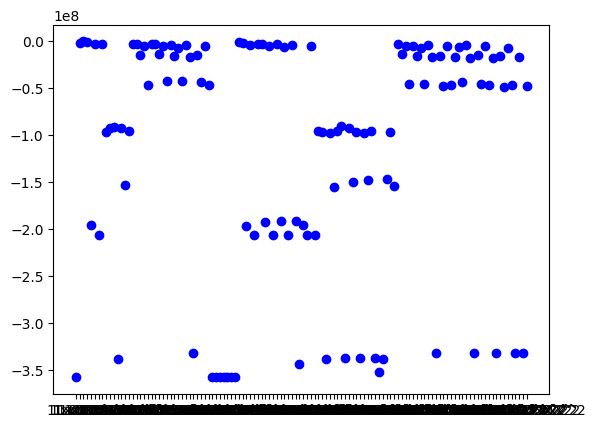

In [69]:
myList = sorted(Fs_3.items())
x, y = zip(*myList)
print(y)
comb = []
for i in range(len(x)):
    a = list(x[i])
    c_temp = []
    for c in a:
        c_temp.append(feat_names[c])
    comb.append(' '.join(c_temp))
plt.scatter(comb, np.array(y), color='blue', marker='o', label='Free Energies')

We can print the lowest 5 combinations.

[[-3.57995273e+08]]


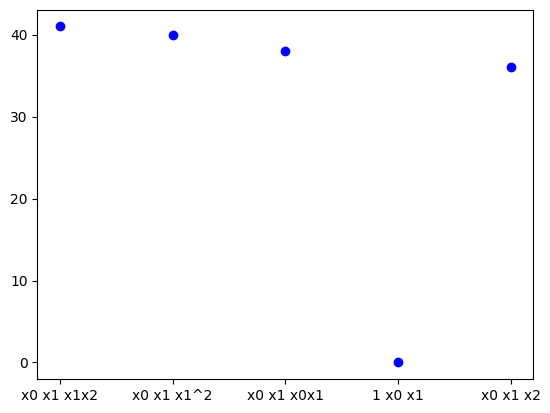

In [70]:
lowest5 = np.argsort(np.array(y).reshape(-1))[:5]
comb5 = []
Fs5 = []
for i in range(len(lowest5)):
    comb5.append(comb[lowest5[i]])
    Fs5.append(lowest5[i])

plt.scatter(comb5, Fs5, color='blue', marker='o')
print(y[lowest5[0]])

Repeat again for the set of subsets of $P(\Xi)$ containing 2 elements.

((0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9))


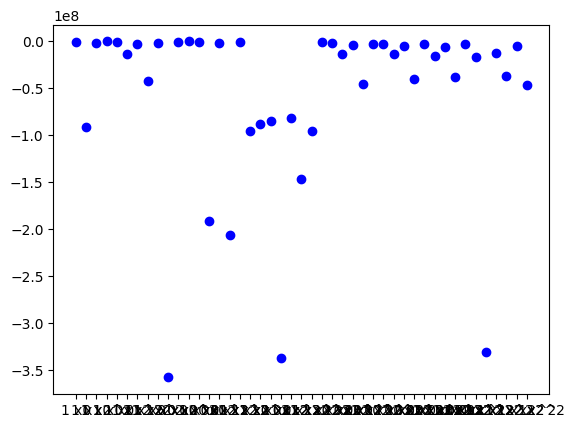

In [65]:
gammas_2, Fs_2, mean_coefs_2 = free_energy_coefs(C, V, .1, 2, num_feats, 0)
myList_2 = sorted(Fs_2.items())
x_2, y_2 = zip(*myList_2)
print(x_2)
comb_2 = []
for i in range(len(x_2)):
    a = list(x_2[i])
    c_temp = []
    for c in a:
        c_temp.append(feat_names[c])
    comb_2.append(' '.join(c_temp))
plt.scatter(comb_2, np.array(y_2), color='blue', marker='o', label='Free Energies')

[[-3.5799504e+08]]


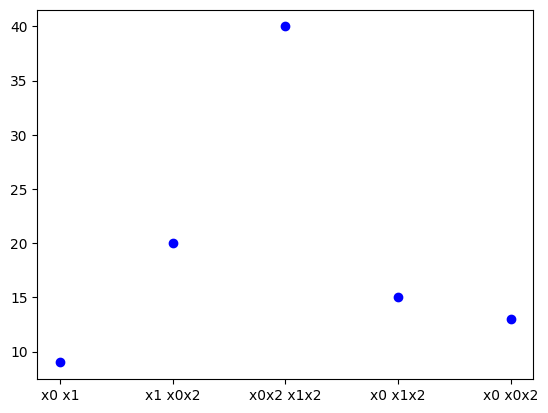

In [66]:
lowest5_2 = np.argsort(np.array(y_2).reshape(-1))[:5]
comb5_2 = []
Fs5_2 = []
for i in range(len(lowest5_2)):
    comb5_2.append(comb_2[lowest5_2[i]])
    Fs5_2.append(lowest5_2[i])

plt.scatter(comb5_2, Fs5_2, color='blue', marker='o')
print(y_2[lowest5_2[0]])

Consider all features?

((0, 1, 2, 3, 4, 5, 6, 7, 8, 9),)
(AxesArray([[-3.579964e+08]]),)


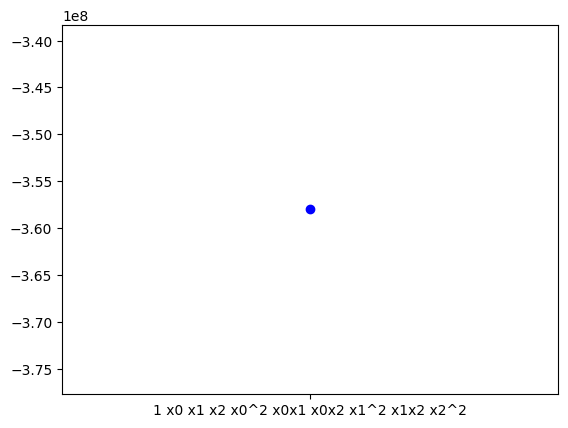

In [68]:
gammas_all, Fs_all, mean_coefs_all = free_energy_coefs(C, V, .1, num_feats, num_feats, 0)
myList_all = sorted(Fs_all.items())
x_all, y_all = zip(*myList_all)
print(x_all)
comb_none = []
for i in range(len(x_all)):
    a = list(x_all[i])
    c_temp = []
    for c in a:
        c_temp.append(feat_names[c])
    comb_none.append(' '.join(c_temp))
plt.scatter(comb_none, np.array(y_all), color='blue', marker='o', label='Free Energies')
print(y_all)